In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from datetime import datetime
from io import BytesIO
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']  # 微軟正黑體、黑體、蘋果字型等
rcParams['axes.unicode_minus'] = False  # 解決負號顯示為方框的問題

### 一、資料讀取、初步整理
> 將資料轉成日期格式(都已經是月底資料，但還是以1號做代表，簡單處理)
>
> 月報酬率要換成小數形式
>
> 某些欄位格式換成浮點數、某些換成object

In [2]:
df = pd.read_pickle('BacktestData.pkl')
df['對照用年月'] = pd.to_datetime(df['對照用年月'])
df['下一個月報酬率%'] = df['下一個月報酬率%'] /100
df.head(3)

C:\Users\User\AppData\Local\Temp\ipykernel_18232\1978998712.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['對照用年月'] = pd.to_datetime(df['對照用年月'])


,證券代碼,對照用年月,外資月平均持股率,投信月平均持股率,自營月平均持股率,合計月平均持股率,外資月平均週轉率,投信月平均週轉率,自營商月平均週轉率,單月營收成長率％,...,本週以來報酬率 %,本月以來報酬率 %,本季以來報酬率 %,本年以來報酬率 %,超額報酬(週)-大盤,超額報酬(月)-大盤,超額報酬(季)-大盤,超額報酬(年)-大盤,下一個月報酬率%,TSE產業名
0,1101 台泥,2013-02-01,37.186923,1.975385,0.043077,39.207692,0.131538,0.014615,0.012308,28.20,...,-1.0403,-4.6365,-2.1849,-2.1849,1.1103,-5.2474,-4.1922,9.2376,-0.014454,M1100 水泥工業
1,1102 亞泥,2013-02-01,18.820000,0.953077,0.005385,19.776923,0.086923,0.001538,0.003846,55.10,...,0.2711,-1.4648,-0.9371,-0.9371,3.5615,-2.0757,-5.1297,10.3943,-0.014866,M1100 水泥工業
2,1103 嘉泥,2013-02-01,4.946154,0.020769,0.020000,4.985385,0.006154,0.000000,0.000000,-18.85,...,0.0001,0.3598,0.7220,0.7220,1.6332,-0.2511,0.3021,6.8882,-0.057348,M1100 水泥工業


### 二、因子欄位群組定義

In [3]:
investment_cols = ['TSE產業名','外資月平均持股率','投信月平均持股率','自營月平均持股率','合計月平均持股率','外資月平均週轉率','投信月平均週轉率','自營商月平均週轉率']
revenue_cols = ['TSE產業名','單月營收成長率％','累計營收成長率％','創新高/低(歷史)','近3月營收均值高於12月營收均值']
tech_cols = ['TSE產業名','月週轉率','月成交值佔大盤比例','股價淨值比','股價營收比','股利殖利率','現金股利率','高低價差比例']
past_return_cols = ['TSE產業名','本週以來報酬率 %','本月以來報酬率 %','本季以來報酬率 %','本年以來報酬率 %','超額報酬(週)-大盤','超額報酬(月)-大盤','超額報酬(季)-大盤','超額報酬(年)-大盤']

### 三、定義函數：提取主成分分析的因子、滾動窗口切分資料、計算回測指標用途

In [4]:
# PLS：將欄位轉成一個主成分因子
def extract_pls_feature(train_X, train_y, apply_X, n_components=1):
    encoder = ColumnTransformer([
        ('cat', OneHotEncoder(drop='first', sparse_output=False), train_X.select_dtypes(include='object').columns.tolist()) # 格式是object就進行類別轉換
    ], remainder='passthrough')

    train_encoded = encoder.fit_transform(train_X)
    apply_encoded = encoder.transform(apply_X)
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_encoded)
    apply_scaled = scaler.transform(apply_encoded)
    pls = PLSRegression(n_components=n_components)
    pls.fit(train_scaled, train_y)
    return pls.transform(apply_scaled)


In [5]:
def rolling_split(df, start_date, end_date):
    split_data = []
    # 測試集的起始時間 = 訓練起始日 + 3年（同原本）
    current_test_date = pd.to_datetime(start_date) + pd.DateOffset(years=3)
    while current_test_date <= pd.to_datetime(end_date):
        # 訓練集：T-36月 ~ T-13月
        train_start = current_test_date - pd.DateOffset(months=36)
        train_end = current_test_date - pd.DateOffset(months=13)
        train_set = df[(df['對照用年月'] >= train_start) & (df['對照用年月'] <= train_end)].copy()
        # 驗證集：T-12月 ~ T-1月
        val_start = current_test_date - pd.DateOffset(months=12)
        val_end = current_test_date - pd.DateOffset(months=1)
        val_set = df[(df['對照用年月'] >= val_start) & (df['對照用年月'] <= val_end)].copy()
        # 測試集：T月
        test_set = df[df['對照用年月'] == current_test_date].copy()
        split_data.append((train_set, val_set, test_set))
        current_test_date += pd.DateOffset(months=1)
    return split_data

In [6]:
def report_metrics(returns):
    returns = np.array(returns)
    total_return = np.prod(1 + returns) - 1
    ann_return = (1 + total_return) ** (12 / len(returns)) - 1 if len(returns) > 0 else np.nan
    std = np.std(returns)
    ann_vol = std * np.sqrt(12)
    sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan
    win_rate = np.mean(returns > 0)

    # 最大回撤
    cumulative = np.cumprod(1 + returns)
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    max_dd = drawdown.min() if len(drawdown) > 0 else np.nan

    # Calmar Ratio
    calmar = ann_return / abs(max_dd) if max_dd != 0 else np.nan

    # Sortino Ratio
    downside = np.where(returns < 0, returns, 0)
    downside_std = np.std(downside)
    ann_downside_vol = downside_std * np.sqrt(12)
    sortino = ann_return / ann_downside_vol if ann_downside_vol != 0 else np.nan

    # 盈虧比
    profits = returns[returns > 0]
    losses = returns[returns < 0]
    if len(losses) == 0:
        pl_ratio = np.inf
    elif losses.mean() == 0:
        pl_ratio = np.nan
    else:
        pl_ratio = profits.mean() / abs(losses.mean()) if len(profits) > 0 else 0

    return {
        "annualized_return": ann_return,
        "annualized_volatility": ann_vol,
        "sharpe_ratio": sharpe,
        "win_rate": win_rate,
        "max_drawdown": max_dd,
        "calmar_ratio": calmar,
        "sortino_ratio": sortino,
        "profit_loss_ratio": pl_ratio
    }

### 四、回測本身

In [7]:
strategy_returns = []
benchmark_returns = []
dates_list = []
test_predictions = []
monthly_shap_values = []

splits = rolling_split(df, "2013-02-01", "2024-12-01")

for train_set, val_set, test_set in splits:
    for factor_name, cols, n_comp in [
        ("inv_factor", investment_cols, 2),
        ("rev_factor", revenue_cols, 1),
        ("tech_factor", tech_cols, 1),
        ("ret_factor", past_return_cols, 2),
    ]:
        train_f = extract_pls_feature(train_set[cols], train_set['下一個月報酬率%'], train_set[cols], n_components=n_comp)
        val_f = extract_pls_feature(train_set[cols], train_set['下一個月報酬率%'], val_set[cols], n_components=n_comp)
        test_f = extract_pls_feature(train_set[cols], train_set['下一個月報酬率%'], test_set[cols], n_components=n_comp)
        for i in range(n_comp):
            train_set[f'{factor_name}_{i+1}'] = train_f[:, i]
            val_set[f'{factor_name}_{i+1}'] = val_f[:, i]
            test_set[f'{factor_name}_{i+1}'] = test_f[:, i]

    features = [col for col in train_set.columns if '_factor_' in col]
    X_train = train_set[features]
    y_train = train_set['下一個月報酬率%']
    X_val = val_set[features]
    y_val = val_set['下一個月報酬率%']
    X_test = test_set[features]
    y_test = test_set['下一個月報酬率%']

    # 直接用預設參數訓練
    model = lgb.LGBMRegressor(verbose=-1)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    test_set = test_set.copy()
    test_set['預測報酬率'] = preds
    selected = test_set[test_set['預測報酬率'] > 0]
    if not selected.empty:
        mean_return = selected['下一個月報酬率%'].mean()
    else:
        mean_return = 0.0
    benchmark_return = test_set['下一個月報酬率%'].mean()
    strategy_returns.append(mean_return)
    benchmark_returns.append(benchmark_return)
    dates_list.append(test_set['對照用年月'].iloc[0])
    monthly_prediction = test_set[['對照用年月', '證券代碼', '預測報酬率', '下一個月報酬率%']].copy()
    test_predictions.append(monthly_prediction)

### 五、計算指標

In [8]:
# 策略 vs Benchmark 統計
performance_df = pd.DataFrame({
    '月份': dates_list,
    '月策略報酬率': strategy_returns,
    'Benchmark報酬率': benchmark_returns
})
performance_df['策略累積報酬'] = (1 + performance_df['月策略報酬率']).cumprod() - 1
performance_df['Benchmark累積報酬'] = (1 + performance_df['Benchmark報酬率']).cumprod() - 1
performance_df

,月份,月策略報酬率,Benchmark報酬率,策略累積報酬,Benchmark累積報酬
0,2016-02-01,0.025519,0.023617,0.025519,0.023617
1,2016-03-01,-0.030901,-0.034169,-0.006170,-0.011358
2,2016-04-01,0.001569,0.001623,-0.004611,-0.009754
3,2016-05-01,0.021763,0.019777,0.017052,0.009830
4,2016-06-01,0.045354,0.045351,0.063180,0.055627
...,...,...,...,...,...
102,2024-08-01,-0.006912,-0.007551,3.281637,2.856554
103,2024-09-01,-0.021212,-0.024734,3.190817,2.761167
104,2024-10-01,-0.006611,-0.014875,3.163110,2.705219
105,2024-11-01,-0.009443,-0.011794,3.123798,2.661521


In [9]:
# 假設你已用最新版 report_metrics
s_metrics = report_metrics(strategy_returns)
b_metrics = report_metrics(benchmark_returns)

print("=== 策略 vs Benchmark 績效比較 ===")
print(f"策略年化報酬率     : {s_metrics['annualized_return']:.2%}")
print(f"策略年化波動率     : {s_metrics['annualized_volatility']:.2%}")
print(f"策略 Sharpe Ratio  : {s_metrics['sharpe_ratio']:.2f}")
print(f"策略勝率           : {s_metrics['win_rate']:.2%}")
print(f"策略最大回撤       : {s_metrics['max_drawdown']:.2%}")
print(f"策略 Calmar Ratio  : {s_metrics['calmar_ratio']:.2f}")
print(f"策略 Sortino Ratio : {s_metrics['sortino_ratio']:.2f}")
print(f"策略盈虧比         : {s_metrics['profit_loss_ratio']:.2f}")
print('===============================')
print(f"Benchmark年化報酬率: {b_metrics['annualized_return']:.2%}")
print(f"Benchmark波動率    : {b_metrics['annualized_volatility']:.2%}")
print(f"Benchmark Sharpe   : {b_metrics['sharpe_ratio']:.2f}")
print(f"Benchmark 勝率     : {b_metrics['win_rate']:.2%}")
print(f"Benchmark最大回撤  : {b_metrics['max_drawdown']:.2%}")
print(f"Benchmark Calmar   : {b_metrics['calmar_ratio']:.2f}")
print(f"Benchmark Sortino  : {b_metrics['sortino_ratio']:.2f}")
print(f"Benchmark盈虧比    : {b_metrics['profit_loss_ratio']:.2f}")

=== 策略 vs Benchmark 績效比較 ===
策略年化報酬率     : 17.05%
策略年化波動率     : 15.47%
策略 Sharpe Ratio  : 1.10
策略勝率           : 68.22%
策略最大回撤       : -19.68%
策略 Calmar Ratio  : 0.87
策略 Sortino Ratio : 1.98
策略盈虧比         : 1.13
Benchmark年化報酬率: 15.53%
Benchmark波動率    : 15.71%
Benchmark Sharpe   : 0.99
Benchmark 勝率     : 67.29%
Benchmark最大回撤  : -20.95%
Benchmark Calmar   : 0.74
Benchmark Sortino  : 1.76
Benchmark盈虧比    : 1.09


In [10]:
performance_df

,月份,月策略報酬率,Benchmark報酬率,策略累積報酬,Benchmark累積報酬
0,2016-02-01,0.025519,0.023617,0.025519,0.023617
1,2016-03-01,-0.030901,-0.034169,-0.006170,-0.011358
2,2016-04-01,0.001569,0.001623,-0.004611,-0.009754
3,2016-05-01,0.021763,0.019777,0.017052,0.009830
4,2016-06-01,0.045354,0.045351,0.063180,0.055627
...,...,...,...,...,...
102,2024-08-01,-0.006912,-0.007551,3.281637,2.856554
103,2024-09-01,-0.021212,-0.024734,3.190817,2.761167
104,2024-10-01,-0.006611,-0.014875,3.163110,2.705219
105,2024-11-01,-0.009443,-0.011794,3.123798,2.661521


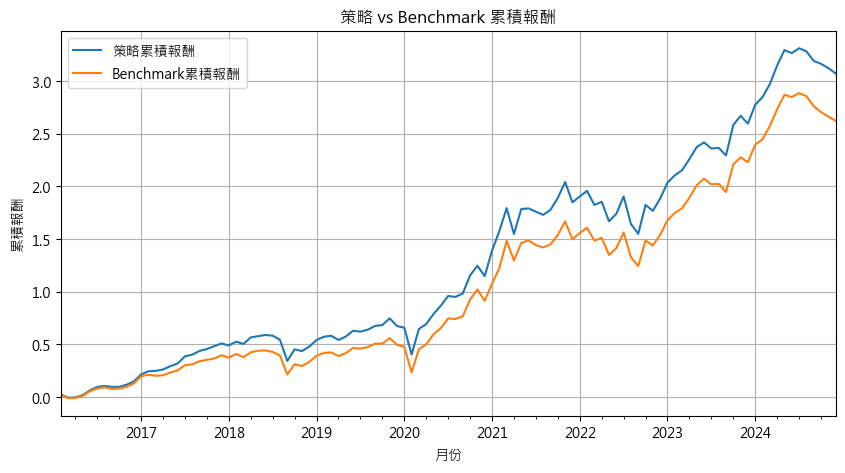

In [11]:
import matplotlib.pyplot as plt
performance_df.set_index('月份')[['策略累積報酬', 'Benchmark累積報酬']].plot(title='策略 vs Benchmark 累積報酬', figsize=(10, 5))
plt.ylabel("累積報酬")
plt.grid(True)
plt.show()

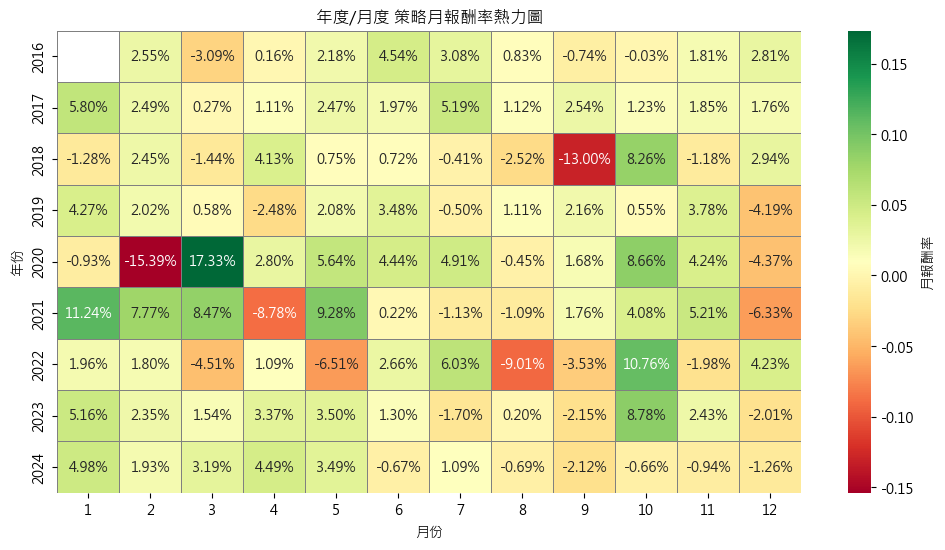

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假設 performance_df 已有 '月份' 與 '月策略報酬率'
df = performance_df.copy()
df['year'] = df['月份'].dt.year
df['month'] = df['月份'].dt.month

# 轉成 heatmap 格式
pivot_table = df.pivot(index='year', columns='month', values='月策略報酬率')

plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_table,
    annot=True, fmt=".2%", cmap="RdYlGn",
    linewidths=0.5, linecolor='gray',
    cbar_kws={'label': '月報酬率'}
)
plt.title('年度/月度 策略月報酬率熱力圖')
plt.xlabel('月份')
plt.ylabel('年份')
plt.show()